In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle
import os
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class DataProcessor:
    def __init__(self, person, weight, attempt):
        self.person = person
        self.weight = weight
        self.attempt = attempt

    def load_data(self, input_file):
        data = []
        file_size = os.path.getsize(input_file)
        with open(input_file, 'rb') as f:
            pbar = tqdm(total=file_size, unit='B', unit_scale=True, desc="Loading data")
            while True:
                try:
                    position = f.tell()
                    data.append(pickle.load(f))
                    pbar.update(f.tell() - position)
                except EOFError:
                    break
            pbar.close()
        return data

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_data, out_channels=64, kernel_conv=3, kernel_pool=2, hidden_lstm=64, layers_lstm=2, num_classes=5, batch_size=64, dropout_prob=0.1):
        super(CNN_LSTM, self).__init__()

        # 1D Convolutional Layer
        self.conv1 = nn.Conv1d(in_channels=num_data, out_channels=out_channels, kernel_size=kernel_conv)
        self.prelu1 = nn.PReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=kernel_pool)
        self.dropout1 = nn.Dropout(p=dropout_prob)  # Dropout layer after pooling
        self.batch_norm1 = nn.BatchNorm1d(out_channels)  # Batch Normalization layer after pooling

        # LSTM layers
        self.lstm = nn.LSTM(out_channels, hidden_lstm, layers_lstm, batch_first=True, dropout=dropout_prob)

        # Fully connected layer for classification
        self.fc1 = nn.Linear(hidden_lstm, num_classes)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 1e-1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # x shape should be (batch_size, num_data, time_steps)
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, time_steps, num_data)
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.pool1(x)  # Shape should be (batch_size, out_channels, new_time_steps)
        x = self.batch_norm1(x)  # Apply Batch Normalization
        x = self.dropout1(x)  # Apply Dropout

        # LSTM input shape should be (batch_size, new_time_steps, out_channels)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)

        # Use only the last output of the LSTM sequence
        x = x[:, -1, :]

        x = self.fc1(x)
        return F.softmax(x, dim=1)

In [ ]:
def train(model, train_loader, criterion, optimizer, epochs=3):
    model.train()
    losses = []
    accuracy = []
    correct_guess = 0
    total_guess = 0
    total_batches = math.ceil(len(train_loader.dataset) / batch_size)
    for epoch in range(epochs):
        running_loss = 0.0
        print('-----------EPOCH %d-----------' % (epoch + 1))
        for i, (inputs, labels) in enumerate(train_loader):
            if len(train_loader.dataset) % batch_size != 0 and i == total_batches - 1:
                break
            optimizer.zero_grad()
            outputs = model(inputs.float())
            labels = labels.flatten()
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total_guess += batch_size
            for j in range(batch_size):
                if torch.argmax(outputs, dim=1)[j] == labels[j]:
                    correct_guess += 1
            if i == 0:
                print('[episode: %d] loss: %f' % (i + 1, running_loss / 1), ', accuracy: ', correct_guess/total_guess)
                losses.append(running_loss / 1)
                accuracy.append(correct_guess / total_guess)
                correct_guess = 0
                total_guess = 0
                running_loss = 0.0
            if (i + 1) % 100 == 0:
                print('[episode: %d] loss: %f' % (i + 1, running_loss / 100), ', accuracy: ', correct_guess/total_guess)
                losses.append(running_loss / 100)
                accuracy.append(correct_guess / total_guess)
                correct_guess = 0
                total_guess = 0
                running_loss = 0.0

    return losses, accuracy

def test(model, test_loader, criterion):
    model.eval()
    total_error = 0
    correct_guess = 0
    total_guess = 0

    class_stats = {i: {'correct': 0, 'count': 0, 'guesses': 0, 'pred_dist': {j: 0 for j in range(5)}} for i in range(5)}

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs.float())
            labels = labels.flatten()
            loss = criterion(outputs, labels.long())
            total_error += loss.item()
            total_guess += len(labels)

            preds = torch.argmax(outputs, dim=1)
            correct_guess += (preds == labels).sum().item()

            for j in range(len(labels)):
                label = labels[j].item()
                pred = preds[j].item()

                class_stats[label]['count'] += 1
                class_stats[pred]['guesses'] += 1
                class_stats[label]['pred_dist'][pred] += 1

                if label == pred:
                    class_stats[label]['correct'] += 1

            if (i + 1) % 200 == 0:
                print(outputs, labels)

    average_loss = total_error / len(test_loader)
    accuracy = correct_guess / total_guess
    print('Average test loss: {:.4f}'.format(average_loss))
    print(correct_guess, total_guess, accuracy)

    for i in range(5):
        if class_stats[i]['count'] > 0:
            print(f'Class {i}: {class_stats[i]["correct"]}/{class_stats[i]["count"]} correct')
            print(f'Accuracy: {class_stats[i]["correct"] / class_stats[i]["count"]:.4f}')
        if class_stats[i]['guesses'] > 0:
            print(f'Precision: {class_stats[i]["correct"] / class_stats[i]["guesses"]:.4f}')
        print(f'Prediction distribution for true class {i}: {class_stats[i]["pred_dist"]}')


In [ ]:
person = 3311
weight = 5
attempt = 10

# Load `all_data` from the file
input_file_train = '/content/drive/MyDrive/Colab_Notebooks/Master_Thesis/Neural_Network/All_data_file/all_data_train_filt_1s.pkl'
processor = DataProcessor(person, weight, attempt)
print('Loading data...')
all_data_train = processor.load_data(input_file_train)

print(len(all_data_train))

data_list_train = [data for data, label in all_data_train]
label_list_train = [label for data, label in all_data_train]

num_rows_train = len(data_list_train)
indices_train = torch.randperm(num_rows_train).tolist()
shuffled_data_train = [data_list_train[i] for i in indices_train]
shuffled_labels_train = [label_list_train[i] for i in indices_train]

shuffled_dataset_train = CustomDataset(list(zip(shuffled_data_train, shuffled_labels_train)))


Loading data...


Loading data: 100%|██████████| 9.56G/9.56G [02:33<00:00, 62.3MB/s]


315597


In [ ]:
person = 1510
weight = 5
attempt = 10

# Load `all_data` from the file
input_file_test = '/content/drive/MyDrive/Colab_Notebooks/Master_Thesis/Neural_Network/All_data_file/all_data_test_filt_1s.pkl'
processor = DataProcessor(person, weight, attempt)
print('Loading data...')
all_data_test = processor.load_data(input_file_test)

print(len(all_data_test))

data_list_test = [data for data, label in all_data_test]
label_list_test = [label for data, label in all_data_test]

num_rows_test = len(data_list_test)
indices_test = torch.randperm(num_rows_test).tolist()
shuffled_data_test = [data_list_test[i] for i in indices_test]
shuffled_labels_test = [label_list_test[i] for i in indices_test]

shuffled_dataset_test = CustomDataset(list(zip(shuffled_data_test, shuffled_labels_test)))

Loading data...


Loading data: 100%|██████████| 4.51G/4.51G [01:29<00:00, 50.4MB/s]


148994


In [ ]:
batch_size = 128
train_set = DataLoader(shuffled_dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
test_set = DataLoader(shuffled_dataset_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
num_data = np.shape(shuffled_data_train[0])[1]
time_steps = np.shape(shuffled_data_train[0])[0]
print(num_data, time_steps)

37 100


In [ ]:
num_data = np.shape(shuffled_data_train[0])[1]
time_steps = np.shape(shuffled_data_train[0])[0]
model = CNN_LSTM(num_data, layers_lstm=2, batch_size=batch_size, dropout_prob=0.5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)#, momentum=0.9)

losses, accuracy = train(model, train_set, criterion, optimizer, epochs=1)

-----------EPOCH 1-----------
[episode: 1] loss: 1.609301 , accuracy:  0.2578125
[episode: 100] loss: 1.573304 , accuracy:  0.42558396464646464
[episode: 200] loss: 1.423263 , accuracy:  0.5978125
[episode: 300] loss: 1.218145 , accuracy:  0.76359375
[episode: 400] loss: 1.105863 , accuracy:  0.865859375
[episode: 500] loss: 1.014993 , accuracy:  0.93359375
[episode: 600] loss: 0.983994 , accuracy:  0.94375
[episode: 700] loss: 0.971207 , accuracy:  0.946796875
[episode: 800] loss: 0.963648 , accuracy:  0.95171875
[episode: 900] loss: 0.959460 , accuracy:  0.95796875
[episode: 1000] loss: 0.950840 , accuracy:  0.966328125
[episode: 1100] loss: 0.946964 , accuracy:  0.965859375
[episode: 1200] loss: 0.945731 , accuracy:  0.96484375
[episode: 1300] loss: 0.940190 , accuracy:  0.969765625
[episode: 1400] loss: 0.938548 , accuracy:  0.970546875
[episode: 1500] loss: 0.937621 , accuracy:  0.97078125
[episode: 1600] loss: 0.938403 , accuracy:  0.969921875
[episode: 1700] loss: 0.932727 , acc

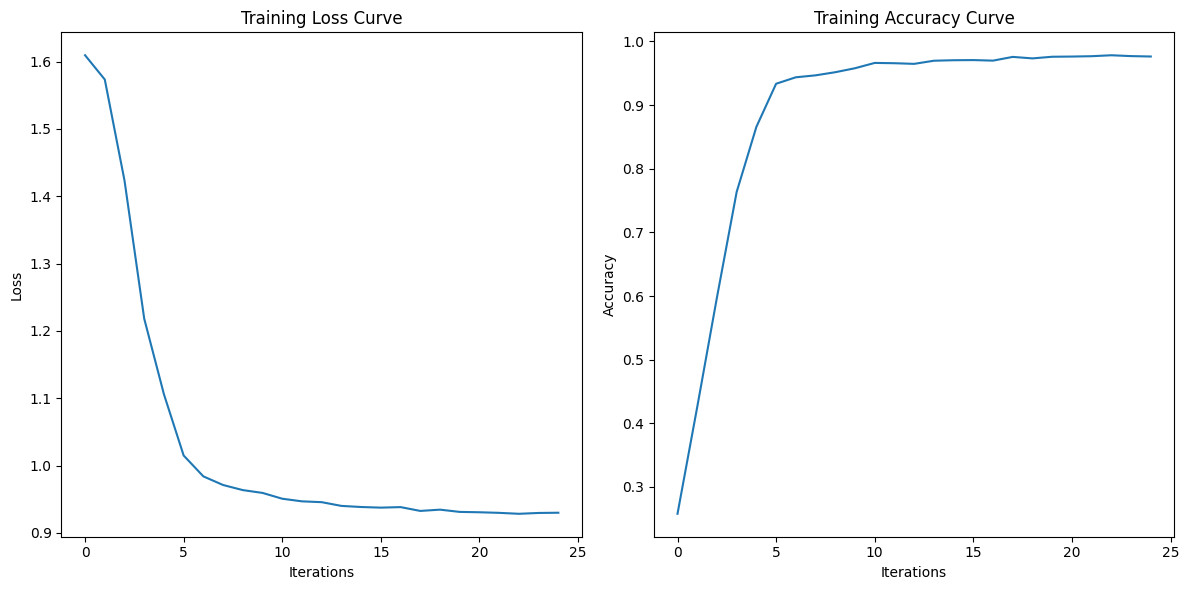

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(losses)
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss Curve')
axs[1].plot(accuracy)
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy Curve')
plt.tight_layout()
plt.show()

In [ ]:
test(model, test_set, criterion)

tensor([[2.3941e-04, 1.8580e-04, 2.2728e-04, 9.9907e-01, 2.7639e-04],
        [9.2937e-05, 2.7285e-04, 9.9913e-01, 4.9185e-04, 1.5007e-05],
        [1.6302e-04, 1.5422e-04, 2.0636e-04, 9.9931e-01, 1.6205e-04],
        [5.3730e-04, 3.7783e-01, 6.0900e-01, 1.2296e-02, 3.3120e-04],
        [4.1603e-01, 7.4155e-03, 4.7165e-03, 9.4249e-03, 5.6241e-01],
        [2.0395e-04, 5.3984e-03, 3.4137e-03, 9.9015e-01, 8.3586e-04],
        [7.0021e-05, 9.9905e-01, 1.3384e-04, 2.6471e-04, 4.7777e-04],
        [9.9905e-01, 1.3181e-04, 8.4682e-05, 2.2121e-04, 5.1304e-04],
        [9.9902e-01, 1.4467e-04, 9.8107e-05, 2.2130e-04, 5.1647e-04],
        [9.9910e-01, 1.2439e-04, 8.6454e-05, 2.1645e-04, 4.7075e-04],
        [7.6072e-05, 3.3621e-04, 9.9924e-01, 3.3431e-04, 1.7285e-05],
        [4.1321e-04, 3.6222e-04, 2.6280e-05, 1.7648e-04, 9.9902e-01],
        [8.0083e-05, 9.9939e-01, 1.2795e-04, 1.1601e-04, 2.8887e-04],
        [5.2326e-04, 3.9248e-04, 4.7326e-05, 2.6888e-04, 9.9877e-01],
        [2.1012e-03,